Standardized Precipitation Index (SPI)
---
- used to characterize meteorological drought on a range of timescales. On short timescales, the SPI is closely related to soil moisture, while at longer timescales, the SPI can be related to groundwater and reservoir storage. The SPI can be compared across regions with markedly different climates. It quantifies observed precipitation as a standardized departure from a selected probability distribution function that models the raw precipitation data. The raw precipitation data are typically fitted to a gamma or a Pearson Type III distribution, and then transformed to a normal distribution.

- Concerns have been raised about the utility of the SPI as a measure of changes in drought associated with climate change, as it does not deal with changes in evapotranspiration.


useful link: https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-index-spi

Import Packages
---
Github:  https://github.com/jeffjay88/Climate_Indices

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
data = pd.read_csv(r"khariar.csv", usecols=[2])
data

,rainfall
0,36.91
1,5.27
2,26.37
3,26.37
4,116.02
...,...
487,200.22
488,330.78
489,21.12
490,35.56


In [3]:
data = data.set_index(
    pd.date_range('1981','2022', freq='M')
)
data.head(5)

,rainfall
1981-01-31,36.91
1981-02-28,5.27
1981-03-31,26.37
1981-04-30,26.37
1981-05-31,116.02


Load Data
---

In [4]:
# data = pd.read_csv('new_data.csv', usecols=[1])
# data = data.set_index(
#     pd.date_range('1959','1989', freq='M')
# )
# data.head(5)

SPI Function (self-defined)
---

In [5]:
#Standardized Precipitation Index Function
def spi(ds, thresh):
    #ds - data ; thresh - time interval / scale
    
    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(thresh, center=False).mean()
    
    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In[ np.isinf(ds_In) == True] = np.nan  #Change infinity to NaN
    
    #Overall Mean of Moving Averages
    ds_mu = np.nanmean(ds_ma)
    
    #Summation of Natural log of moving averages
    ds_sum = np.nansum(ds_In)
        
    #Computing essentials for gamma distribution
    n = len(ds_In[thresh-1:])                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)
    
    #Gamma Distribution (CDF)
    gamma = st.gamma.cdf(ds_ma, a=alpha, scale=beta)  
    
    #Standardized Precipitation Index   (Inverse of CDF)
    norm_spi = st.norm.ppf(gamma, loc=0, scale=1)  #loc is mean and scale is standard dev.
    
    return ds_ma, ds_In, ds_mu, ds_sum, n, A, alpha, beta, gamma, norm_spi

Perform SPI computation on Data at Varying Times
---

In [6]:
times = [1,3, 6, 9, 12, 24,48]
for i in times:
    x = spi(data['rainfall'], i)
    data['spi_'+str(i)] = x[9]

C:\Users\asitg\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\asitg\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Visualization of SPI
---

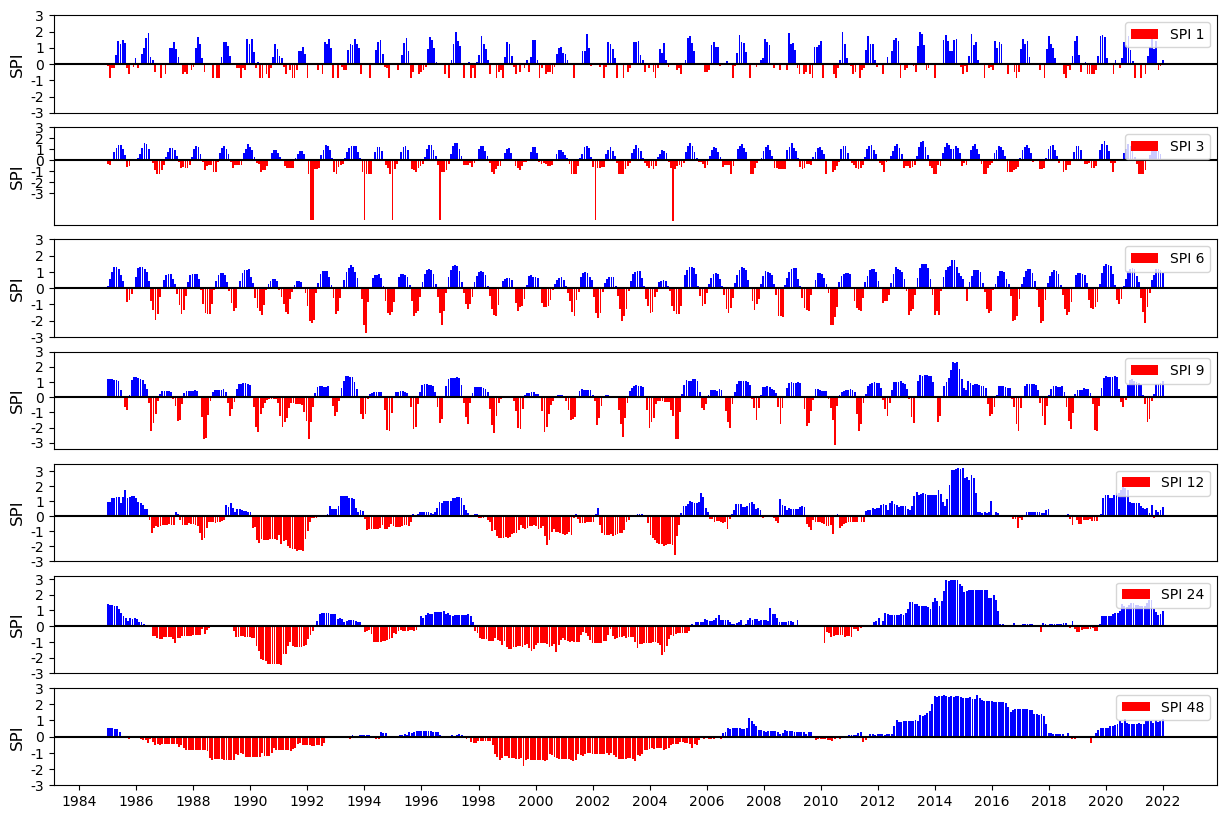

In [7]:
fig, axes = plt.subplots(nrows=7, figsize=(15, 10))
plt.subplots_adjust(hspace=0.15)
for i, ax in enumerate(axes):
    col_scheme=np.where(data['spi_'+str(times[i])]>0, 'b','r')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.bar(data.index, data['spi_'+str(times[i])], width=25, align='center', color=col_scheme, label='SPI '+str(times[i]))
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.legend(loc='upper right')
    ax.set_yticks(range(-3,4), range(-3,4))
    ax.set_ylabel('SPI', fontsize=12)
    
    if i<len(times)-1:
        ax.set_xticks([],[])

In [8]:
data

,rainfall,spi_1,spi_3,spi_6,spi_9,spi_12,spi_24,spi_48
1981-01-31,36.91,-0.098677,NaN,NaN,NaN,NaN,NaN,NaN
1981-02-28,5.27,-0.860330,NaN,NaN,NaN,NaN,NaN,NaN
1981-03-31,26.37,-0.254117,-0.349032,NaN,NaN,NaN,NaN,NaN
1981-04-30,26.37,-0.254117,-0.421008,NaN,NaN,NaN,NaN,NaN
1981-05-31,116.02,0.551637,0.094060,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-08-31,200.22,0.954592,1.253272,0.781117,0.182929,-0.143392,1.074013,0.840625
2021-09-30,330.78,1.402750,1.373676,1.176952,0.847009,0.419545,0.873854,1.008699
2021-10-31,21.12,-0.350124,0.884226,1.188552,0.885430,0.272565,0.728832,0.920273
2021-11-30,35.56,-0.116547,0.615477,1.108924,0.939842,0.378471,0.804370,0.970060


In [9]:
data.isnull().sum()

rainfall     0
spi_1        0
spi_3        2
spi_6        5
spi_9        8
spi_12      11
spi_24      23
spi_48      47
dtype: int64

In [10]:
data.to_csv('rainfall_Khariar.csv', sep=',', index=False, encoding='utf-8')